# Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

# Functions

In [ ]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

def trend(time, slope=0):
    return slope * time


def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))


def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)


def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

def sequential_window_dataset(series, window_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)

# Dataset Makeing

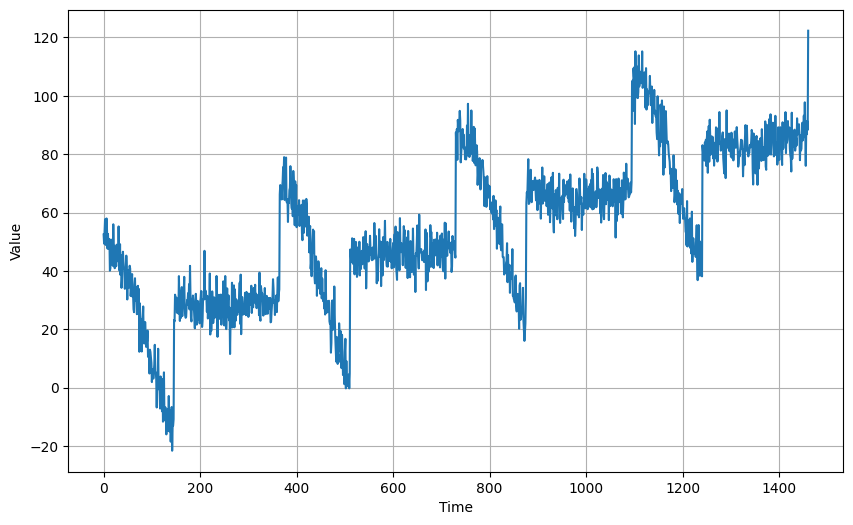

In [ ]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

# Split dataset

In [ ]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

# LSTM RNN Forecasting

In [ ]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                    batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
reset_states = ResetStatesCallback()
optimizer = keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100,
                    callbacks=[lr_schedule, reset_states])

Epoch 1/100
33/33 [==============================] - 6s 13ms/step - loss: 42.2544 - mae: 42.7543 - lr: 1.0000e-08
Epoch 2/100
33/33 [==============================] - 0s 7ms/step - loss: 36.0082 - mae: 36.5082 - lr: 1.1220e-08
Epoch 3/100
33/33 [==============================] - 0s 10ms/step - loss: 29.2601 - mae: 29.7592 - lr: 1.2589e-08
Epoch 4/100
33/33 [==============================] - 0s 11ms/step - loss: 22.0894 - mae: 22.5867 - lr: 1.4125e-08
Epoch 5/100
33/33 [==============================] - 0s 11ms/step - loss: 15.2244 - mae: 15.7175 - lr: 1.5849e-08
Epoch 6/100
33/33 [==============================] - 1s 15ms/step - loss: 11.3452 - mae: 11.8324 - lr: 1.7783e-08
Epoch 7/100
33/33 [==============================] - 0s 13ms/step - loss: 10.5699 - mae: 11.0594 - lr: 1.9953e-08
Epoch 8/100
33/33 [==============================] - 0s 12ms/step - loss: 10.3885 - mae: 10.8792 - lr: 2.2387e-08
Epoch 9/100
33/33 [==============================] - 0s 13ms/step - loss: 10.2198 - mae: 

(1e-08, 0.0001, 0.0, 30.0)

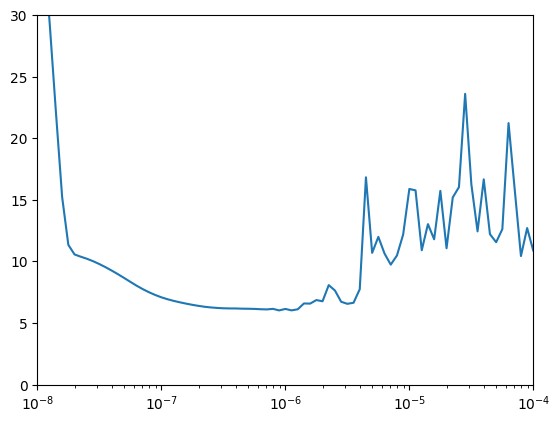

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)
valid_set = sequential_window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(learning_rate=5e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
reset_states = ResetStatesCallback()
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint, reset_states])

Epoch 1/500
33/33 [==============================] - 4s 49ms/step - loss: 23.4207 - mae: 23.9150 - val_loss: 17.2397 - val_mae: 17.7328


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/500
33/33 [==============================] - 0s 10ms/step - loss: 18.1541 - mae: 18.6457 - val_loss: 14.0725 - val_mae: 14.5653
Epoch 3/500
33/33 [==============================] - 0s 10ms/step - loss: 14.8509 - mae: 15.3404 - val_loss: 12.6125 - val_mae: 13.1022
Epoch 4/500
33/33 [==============================] - 0s 10ms/step - loss: 10.5310 - mae: 11.0198 - val_loss: 9.7433 - val_mae: 10.2361
Epoch 5/500
33/33 [==============================] - 0s 10ms/step - loss: 7.5015 - mae: 7.9869 - val_loss: 8.8786 - val_mae: 9.3663
Epoch 6/500
33/33 [==============================] - 1s 16ms/step - loss: 6.2227 - mae: 6.7058 - val_loss: 12.2288 - val_mae: 12.7208
Epoch 7/500
33/33 [==============================] - 1s 16ms/step - loss: 6.2083 - mae: 6.6909 - val_loss: 12.2864 - val_mae: 12.7809
Epoch 8/500
33/33 [==============================] - 0s 14ms/step - loss: 5.8771 - mae: 6.3588 - val_loss: 11.6282 - val_mae: 12.1187
Epoch 9/500
33/33 [==============================] - 1s 15m

In [ ]:
model = keras.models.load_model("my_checkpoint.h5")

In [ ]:
model.reset_states()
rnn_forecast = model.predict(series[np.newaxis, :, np.newaxis])
rnn_forecast = rnn_forecast[0, split_time - 1:-1, 0]

1/1 [==============================] - 1s 643ms/step


In [ ]:
rnn_forecast.shape

(461,)

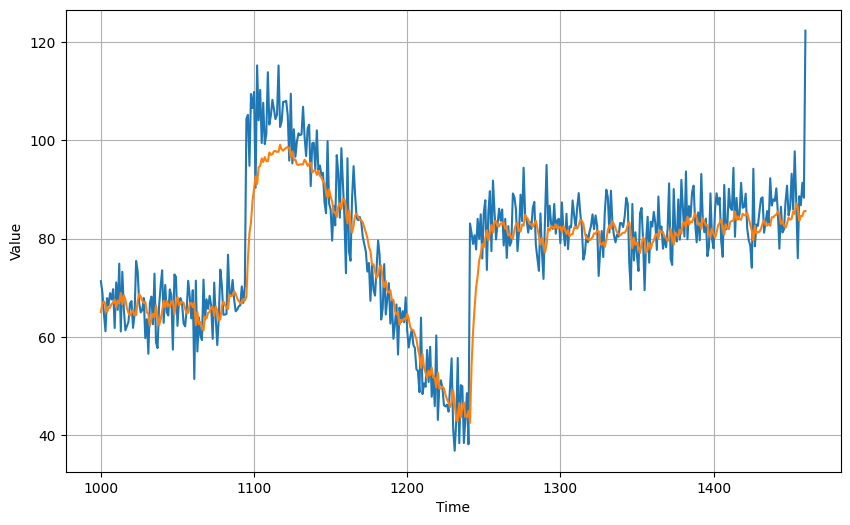

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [ ]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.18353